In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA #tsa=time series analysis
import arch
import re


In [188]:
df = pd.read_csv('SSE_2014-2015.csv') # only input the file's name
change = df['change'].str.strip('%') # select a subset of a dataframe and remove the '%' sign
print(type(change))
# change=change.to_string() #convert the series into string
# change=change.replace(" ","") #remove the space in the string
# change=change.replace("\n","") # remove the newline character
# change=change.splitlines() #convert the string into list
# change=re.sub(r'\n\d?\d?\d?', '', change) #remove the newline character and the trailing numbers, one \d? for one digit
# change=change[1:]
print(change[0:10])
change=pd.to_numeric(change, errors='coerce') #convert the object into float, but the percentage number can't be recognized
change = change/100
print(change[0:10])

<class 'pandas.core.series.Series'>
0    -0.31
1    -1.24
2    -1.80
3     0.08
4    -0.15
5    -0.82
6    -0.71
7    -0.19
8     0.86
9    -0.17
Name: change, dtype: object
0   -0.0031
1   -0.0124
2   -0.0180
3    0.0008
4   -0.0015
5   -0.0082
6   -0.0071
7   -0.0019
8    0.0086
9   -0.0017
Name: change, dtype: float64


<AxesSubplot:>

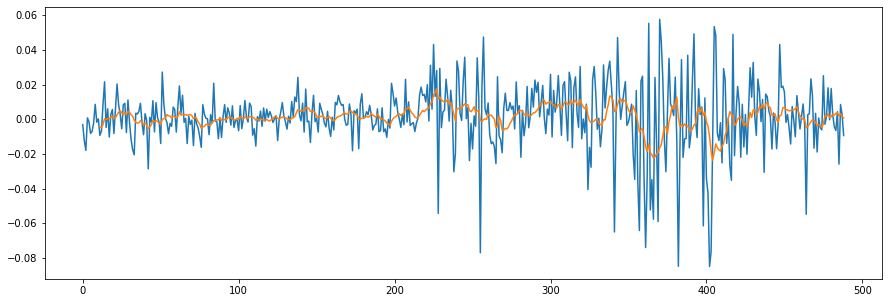

In [189]:
plt.figure(figsize=(15,5))
plt.plot(range(len(change)), change)
change.rolling(12).mean().plot()

In [190]:
t = sm.tsa.stattools.adfuller(change)
print(t) # why the result of adf test is so messy
print("p-value: ",t[1])

(-6.9937640703203146, 7.626298221598321e-10, 9, 479, {'1%': -3.44407586647939, '5%': -2.867592847097137, '10%': -2.5699939338217668}, -2397.8791055144725)
p-value:  7.626298221598321e-10


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


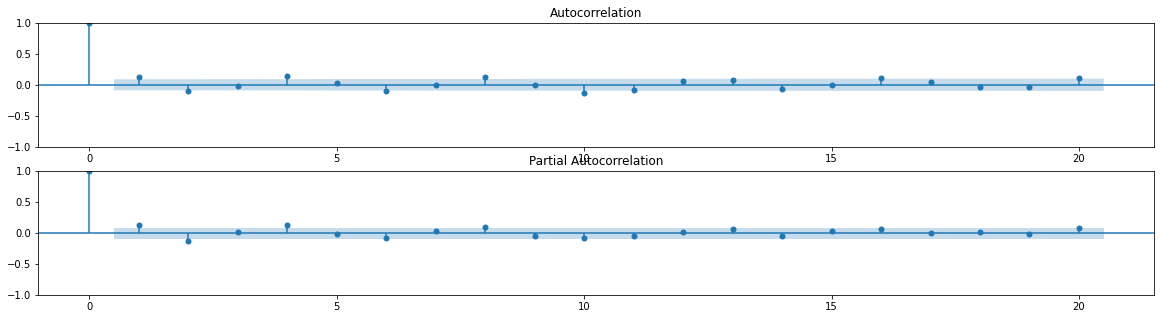

In [191]:
fig = plt.figure(figsize=(20,5))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(change,lags = 20, ax=ax1)
ax2=fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(change,lags = 20, ax=ax2)
# why are we just looking at ar not ma, why is the lag not 4?

In [204]:
model = ARIMA(change, order = (4, 0, 4)).fit()
print(model.params)

const     0.001217
ar.L1    -0.366962
ar.L2    -0.436504
ar.L3    -0.433400
ar.L4     0.402497
ma.L1     0.508769
ma.L2     0.444150
ma.L3     0.478135
ma.L4    -0.253066
sigma2    0.000328
dtype: float64


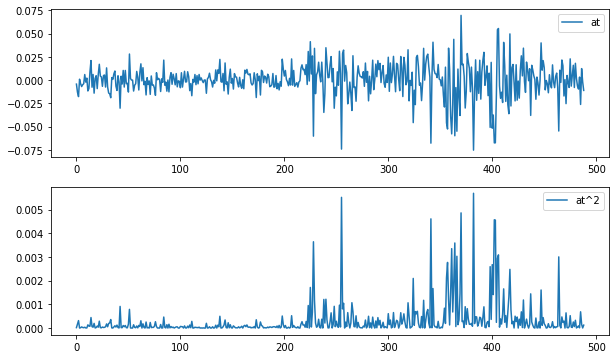

In [198]:
at = change - model.fittedvalues
at2 = np.square(at)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(at,label = 'at')
plt.legend()
plt.subplot(212)
plt.plot(at2,label='at^2')
plt.legend(loc=0)

In [219]:
m = 25 # test for 25 acf
acf,q,p = sm.tsa.acf(at2,nlags=m,qstat=True) # return acf and p-value
out = np.c_[range(1,26),acf[1:],q,p]
output = pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output

array([[1.00000000e+00, 2.27512569e-01, 2.54672069e+01, 4.49966479e-07],
       [2.00000000e+00, 2.68901517e-01, 6.11162516e+01, 5.35518641e-14],
       [3.00000000e+00, 2.49111169e-01, 9.17740159e+01, 9.10925351e-20],
       [4.00000000e+00, 2.22552611e-01, 1.16293651e+02, 3.30434999e-24],
       [5.00000000e+00, 1.85301082e-01, 1.33327033e+02, 4.68094590e-27],
       [6.00000000e+00, 1.71879483e-01, 1.48012620e+02, 2.03568578e-29],
       [7.00000000e+00, 1.50645523e-01, 1.59317235e+02, 4.46558531e-31],
       [8.00000000e+00, 1.10266338e-01, 1.65386431e+02, 1.19371255e-31],
       [9.00000000e+00, 1.01213720e-01, 1.70510653e+02, 4.82999863e-32],
       [1.00000000e+01, 1.44139710e-01, 1.80924762e+02, 1.50578135e-33],
       [1.10000000e+01, 6.37627729e-02, 1.82966955e+02, 2.50074526e-33],
       [1.20000000e+01, 1.56426236e-01, 1.95283564e+02, 3.06401925e-35],
       [1.30000000e+01, 1.60053032e-01, 2.08205013e+02, 2.81193755e-37],
       [1.40000000e+01, 1.14891255e-01, 2.14877238e

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


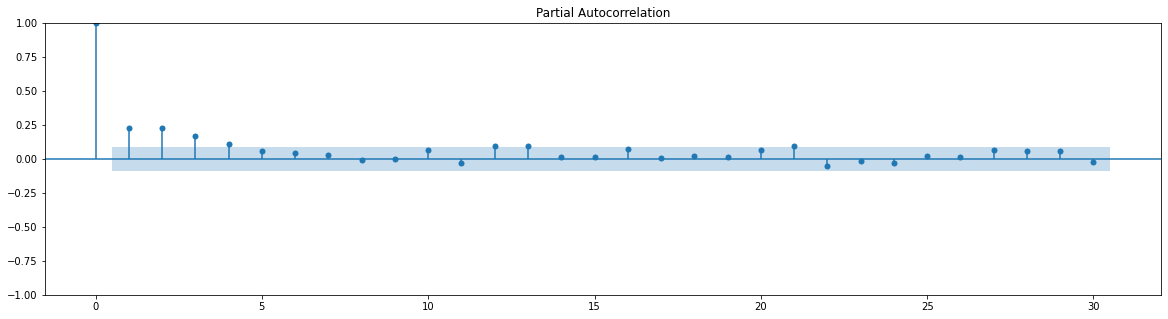

In [196]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(at2,lags = 30,ax=ax1)

In [227]:
train = change[:-10]
test = change[-10:]
am = arch.arch_model(train,mean='AR',lags=8,vol='ARCH',p=4)
result = am.fit()

Iteration:      1,   Func. Count:     16,   Neg. LLF: 142497017.07448986
Iteration:      2,   Func. Count:     38,   Neg. LLF: 13385.100041352243
Iteration:      3,   Func. Count:     57,   Neg. LLF: 500.56757039649096
Iteration:      4,   Func. Count:     75,   Neg. LLF: 1588.1913372050665
Iteration:      5,   Func. Count:     95,   Neg. LLF: 2025209.3996873302
Iteration:      6,   Func. Count:    113,   Neg. LLF: 4701.26255362892
Iteration:      7,   Func. Count:    132,   Neg. LLF: 26899647.52561623
Iteration:      8,   Func. Count:    154,   Neg. LLF: 60749.773096411605
Iteration:      9,   Func. Count:    172,   Neg. LLF: 4679.719167940664
Iteration:     10,   Func. Count:    192,   Neg. LLF: 3056.207668573087
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1279.08351655787
            Iterations: 11
            Function evaluations: 199
            Gradient evaluations: 10


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000341. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [228]:
result.summary
result.params

Const        0.001552
change[1]    0.116869
change[2]   -0.117940
change[3]   -0.064480
change[4]    0.058559
change[5]    0.023901
change[6]   -0.080590
change[7]   -0.059248
change[8]    0.033506
omega        0.000119
alpha[1]     0.173476
alpha[2]     0.182877
alpha[3]     0.173476
alpha[4]     0.173476
Name: params, dtype: float64

479


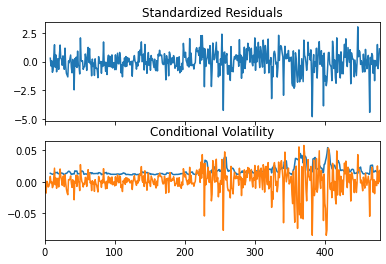

In [234]:
result.plot()
change.plot()
print(len(train))

In [230]:
pre = result.predict(horizon=10,start=478)
print(pre)
# plt.figure(figsize=(10,4))
# plt.plot(test,label='realValue')
pre.plot(label='predictValue')
# plt.plot(np.zeros(10),label='zero')
# plt.legend(loc=0)


AttributeError: 'ARCHModelResult' object has no attribute 'predict'